**Data Link: https://www.kaggle.com/datasets/rakeshkapilavai/extrovert-vs-introvert-behavior-data/data**

Coder: Chau Hung Cheung, Cyrus

Date: 10/6/2025

In [110]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [111]:
df = pd.read_csv('personality_dataset.csv')
print(df.head())
conn = sqlite3.connect("")

   Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
0               4.0         No                      4.0            6.0   
1               9.0        Yes                      0.0            0.0   
2               9.0        Yes                      1.0            2.0   
3               0.0         No                      6.0            7.0   
4               3.0         No                      9.0            4.0   

  Drained_after_socializing  Friends_circle_size  Post_frequency Personality  
0                        No                 13.0             5.0   Extrovert  
1                       Yes                  0.0             3.0   Introvert  
2                       Yes                  5.0             2.0   Introvert  
3                        No                 14.0             8.0   Extrovert  
4                        No                  8.0             5.0   Extrovert  


In [112]:
# handle the missing val(drop the column)
print(df.isnull().sum())

Time_spent_Alone             63
Stage_fear                   73
Social_event_attendance      62
Going_outside                66
Drained_after_socializing    52
Friends_circle_size          77
Post_frequency               65
Personality                   0
dtype: int64


In [113]:
df = df.dropna()
print(df.isnull().sum())

Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64


In [114]:
print(df['Stage_fear'].unique())
print(df['Drained_after_socializing'].unique())
print(df['Personality'].unique())

['No' 'Yes']
['No' 'Yes']
['Extrovert' 'Introvert']


In [115]:
# Encode Categorical Variables
df['Stage_fear'] = df['Stage_fear'].map({"Yes" : 1, "No" : 0})
df['Drained_after_socializing'] = df['Drained_after_socializing'].map({"Yes" : 1, "No" : 0})
df['Personality'] = df['Personality'].map({"Extrovert": 1, "Introvert": 0})
df.describe()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
count,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000
mean,4.522406,0.498991,3.939039,3.013726,0.498991,6.239806,3.559548,0.514332
std,3.491162,0.500100,2.900044,2.257239,0.500100,4.311365,2.927397,0.499895
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,2.000000,1.000000,0.000000,3.000000,1.000000,0.000000
50%,4.000000,0.000000,3.000000,3.000000,0.000000,5.000000,3.000000,1.000000
75%,8.000000,1.000000,6.000000,5.000000,1.000000,10.000000,6.000000,1.000000
max,11.000000,1.000000,10.000000,7.000000,1.000000,15.000000,10.000000,1.000000


In [116]:
# Drop duplicate rows
print(df.duplicated().sum())
df = df.drop_duplicates()

379


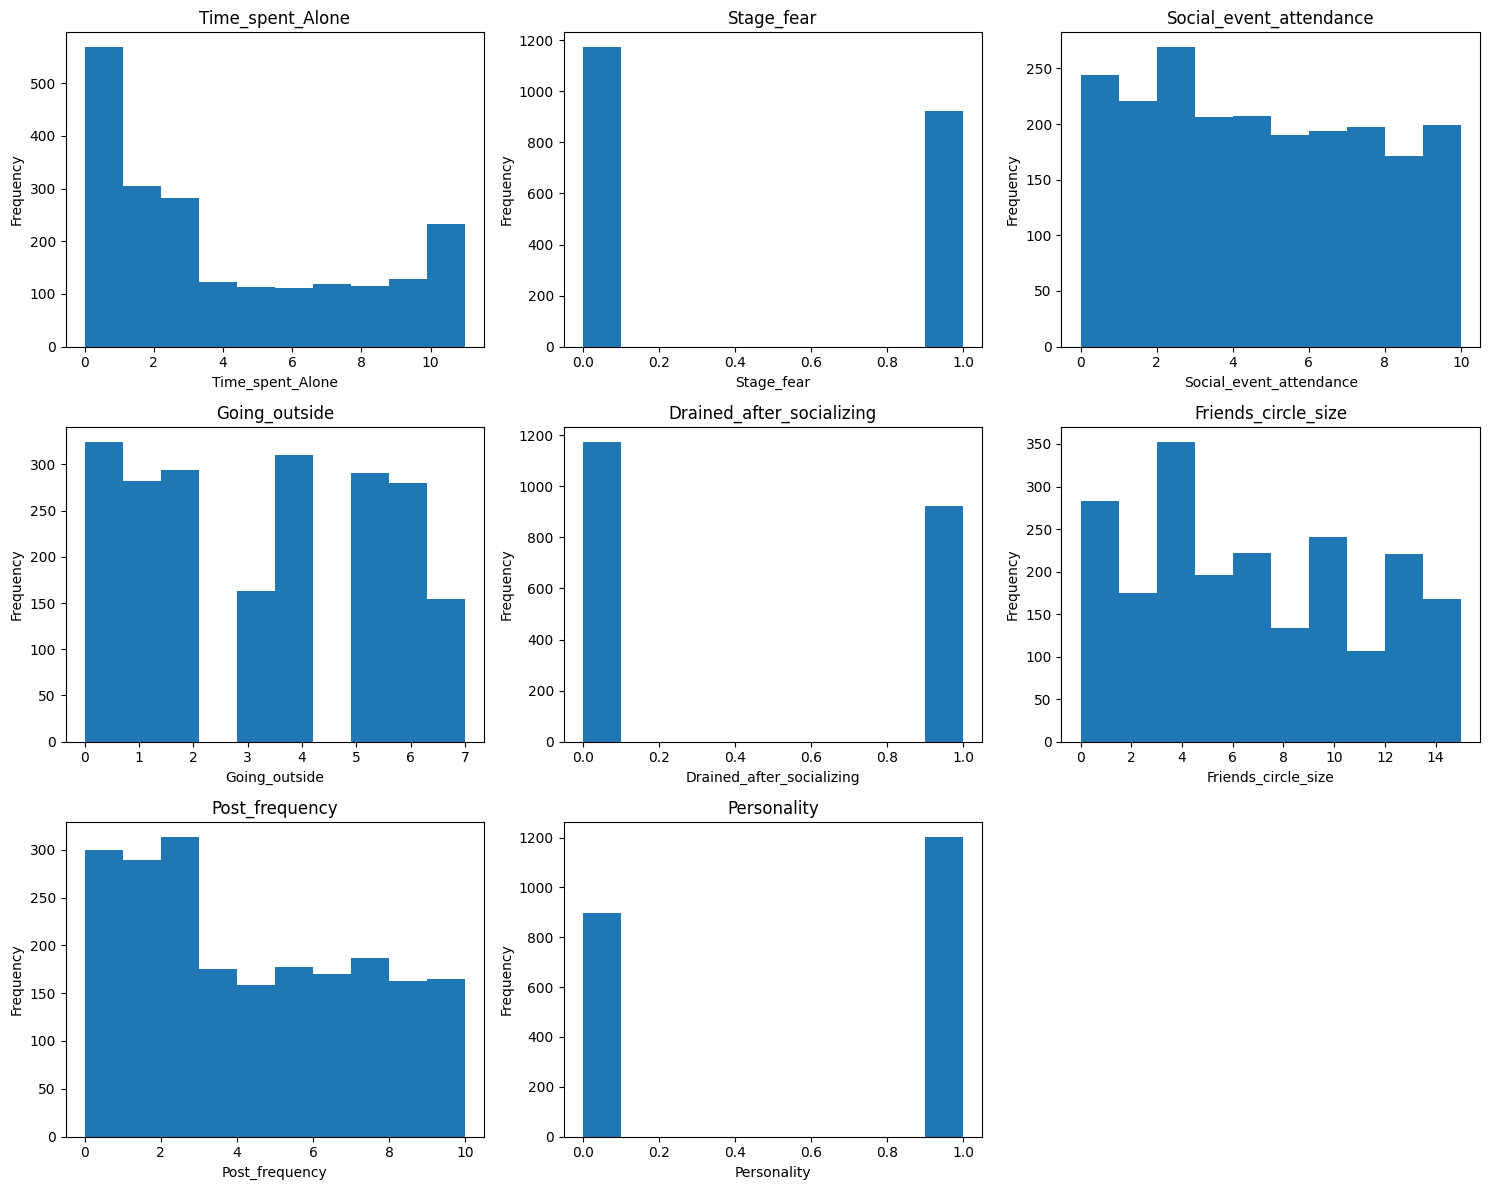

In [117]:
# Visualize the entire dataset at once
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

#Loop Through Numeric Columns and Plot Histograms
for i, col in enumerate(df.select_dtypes(include=['int64', 'float64']).columns):
    df[col].plot(kind='hist', bins=10, ax=axes[i], title=col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() # to ensure that hte labels aint overlapping
plt.show()

In [118]:
# Extrovert": 1, "Introvert": 0
df.groupby("Personality")["Time_spent_Alone"].mean()

,Time_spent_Alone
Personality,
0,6.926421
1,2.139883


In [119]:
df.groupby("Personality")["Social_event_attendance"].mean()

,Social_event_attendance
Personality,
0,1.929766
1,5.945046


In [120]:
df.groupby("Personality")["Going_outside"].mean()

,Going_outside
Personality,
0,1.418060
1,4.612823


In [121]:
df.groupby("Personality")["Friends_circle_size"].mean()

,Friends_circle_size
Personality,
0,3.322185
1,9.079101


In [122]:
df.groupby("Personality")["Post_frequency"].mean()

,Post_frequency
Personality,
0,1.535117
1,5.597835


Short Key value summary:

1. Avg Extrovert spend around 2.139 hrs alone and Introvert spend around 6.926 hrs alone
2. Avg Extrovert and Introvert's frequency of attending social events are around 1.929 and 5.945
3. Avg Extrovert and Introvert's individual goes outside frequency are around 1.418 and 4.612
4. Avg Extrovert and Introvert's friends circle size are around 3.322 and 9.079
5. Frequency of posting on social media of avg Extrovert and Introvert are 1.535 and 5.598


In [123]:
# Feature engineering based on the stats
# Calculate the threshold using the midpoint of the result i just find
df['high_time_alone'] = (df['Time_spent_Alone'] > 4.5325).astype(int)
df['high_social_event'] = (df['Social_event_attendance'] > 3.9370).astype(int)
df['high_going_out'] = (df['Going_outside'] > 3.0150).astype(int)
df['large_friends_circle'] = (df['Friends_circle_size'] > 6.2005).astype(int)
df['high_post_freq'] = (df['Post_frequency'] > 3.5665).astype(int)
print(df.head())

   Time_spent_Alone  Stage_fear  Social_event_attendance  Going_outside  \
0               4.0           0                      4.0            6.0   
1               9.0           1                      0.0            0.0   
2               9.0           1                      1.0            2.0   
3               0.0           0                      6.0            7.0   
4               3.0           0                      9.0            4.0   

   Drained_after_socializing  Friends_circle_size  Post_frequency  \
0                          0                 13.0             5.0   
1                          1                  0.0             3.0   
2                          1                  5.0             2.0   
3                          0                 14.0             8.0   
4                          0                  8.0             5.0   

   Personality  high_time_alone  high_social_event  high_going_out  \
0            1                0                  1              

In [124]:
# Make the feature column
feature_cols = [
    'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance', 'Going_outside',
    'Drained_after_socializing', 'Friends_circle_size', 'Post_frequency',
    'high_time_alone', 'high_social_event', 'high_going_out', 'large_friends_circle', 'high_post_freq'
]
X = df[feature_cols]
y = df['Personality']


In [125]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [126]:
# Train the model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9142857142857143

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       269
           1       0.93      0.93      0.93       361

    accuracy                           0.91       630
   macro avg       0.91      0.91      0.91       630
weighted avg       0.91      0.91      0.91       630



In [127]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Random Forest Accuracy: 0.8857142857142857

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       269
           1       0.93      0.93      0.93       361

    accuracy                           0.91       630
   macro avg       0.91      0.91      0.91       630
weighted avg       0.91      0.91      0.91       630



In [128]:
# Testing
input_data = {
    'Time_spent_Alone': 7.0,
    'Stage_fear': 5,  # 1 for Yes, 0 for No
    'Social_event_attendance': 2.0,
    'Going_outside': 2.5,
    'Drained_after_socializing': 0,  # 1 for Yes, 0 for No
    'Friends_circle_size': 5,
    'Post_frequency': 2.0
}

input_data['high_time_alone'] = int(input_data['Time_spent_Alone'] > 4.5325)
input_data['high_social_event'] = int(input_data['Social_event_attendance'] > 3.9370)
input_data['high_going_out'] = int(input_data['Going_outside'] > 3.0150)
input_data['large_friends_circle'] = int(input_data['Friends_circle_size'] > 6.2005)
input_data['high_post_freq'] = int(input_data['Post_frequency'] > 3.5665)

input_df = pd.DataFrame([input_data])[feature_cols]
print(input_df.head())
input_df

# Result
prediction = model.predict(input_df)[0]
result = "Extrovert" if prediction == 1 else "Introvert"
print("Prediction:", result)

   Time_spent_Alone  Stage_fear  Social_event_attendance  Going_outside  \
0               7.0           5                      2.0            2.5   

   Drained_after_socializing  Friends_circle_size  Post_frequency  \
0                          0                    5             2.0   

   high_time_alone  high_social_event  high_going_out  large_friends_circle  \
0                1                  0               0                     0   

   high_post_freq  
0               0  
Prediction: Introvert
